In [1]:
import os 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import h5py
import numpy as np 


from scipy.integrate import simps
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline

sns.set_context("talk")

%matplotlib inline

In [2]:


# Fit the resolution data to a polynomial for extrapolation
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Create a function to get resolution for any energy
def get_resolution(e,popt):
    return np.maximum(poly_func(e, *popt), 1e-10)  # Ensure non-zero resolution


# Perform Gaussian broadening using convolution with energy-dependent widths
def gaussian_broadening(dos, energy, sigmas):
    broadened_dos = np.zeros_like(dos)
    for i in range(len(energy)):
        # Create a Gaussian kernel centered at each energy point with width sigmas[i]
        kernel = np.exp(-0.5 * ((energy - energy[i]) / sigmas[i])**2)
        kernel /= simps(kernel, energy)  # Normalize the kernel to preserve area
        broadened_dos += dos[i] * kernel  # Convolve DOS with Gaussian kernel
    return broadened_dos

def apply_gaussian_broadening(dos_data,metric='dos total (nm2/ps)',unit_cell_atoms=1):
    energy = dos_data['Energy Transfer (meV)'].values
    dos = dos_data[metric].values

    resolution_data = pd.read_csv('../data/experiment/resolution.csv')
    res_energy = resolution_data['Energy (meV)'].values
    resolution = resolution_data['Resolution'].values
    popt, _ = curve_fit(poly_func, res_energy, resolution)
    
    # Create an array of sigmas for Gaussian broadening based on the resolution function
    sigmas = get_resolution(energy,popt) / np.sqrt(8 * np.log(2))  # Convert FWHM to sigma


    broadened_dos = gaussian_broadening(dos, energy, sigmas)

    # Area normalize both original and broadened DOS
    original_area = simps(dos, energy)
    broadened_area = simps(broadened_dos, energy)

    dos_normalized = dos / original_area
    broadened_dos_normalized = broadened_dos / broadened_area
    return 3*unit_cell_atoms*broadened_dos_normalized

In [3]:
results_directory={"../results/gromacs/nanoparticle/1nm/results/md_phonon_200/":("1",200)
                   ,"../results/gromacs/nanoparticle/2nm/results/md_phonon_200/":("2",200)
                   ,"../results/gromacs/nanoparticle/4nm/results/md_phonon_200/":("4",200)
                   ,"../results/gromacs/nanoparticle/8nm/results/md_phonon_200/":("8",200)
                   ,"../results/gromacs/bulk/results/md_phonon_200/":("bulk",200)
                  ,"../results/gromacs/nanoparticle/1nm/results/md_phonon_300/":("1",300)
                   ,"../results/gromacs/nanoparticle/2nm/results/md_phonon_300/":("2",300)
                   ,"../results/gromacs/nanoparticle/4nm/results/md_phonon_300/":("4",300)
                   ,"../results/gromacs/nanoparticle/8nm/results/md_phonon_300/":("8",300)
                   ,"../results/gromacs/bulk/results/md_phonon_300/":("bulk",300)
                  }
df_list=list()

min_energy=0
max_energy=150

for data_directory,(radius,temperature) in results_directory.items():
    for filename in os.listdir(data_directory):
        if not "dos.h5" in filename:
            continue
        print(os.path.join(data_directory,filename))
        h5file=h5py.File(os.path.join(data_directory,filename))
        data_dict=dict()
        omega_shape=h5file["omega"][:].shape
        for k in h5file.keys():
            data_array=h5file[k][:]
            if data_array.shape != omega_shape or "_0" in k:
                continue
            units=h5file[k].attrs['units']
            data_dict["%s (%s)"%(k.replace("_"," "),units)]=data_array
        df_tmp=pd.DataFrame(data_dict).query("%f < `omega (rad/ps)` and `omega (rad/ps)` < %f"%(min_energy/0.6582,max_energy/0.6582))
        directory_split=data_directory.split("/")
        system=directory_split[3]
        df_tmp["Weight"]=" ".join(filename.split("_")[:-1]).replace('b ','').capitalize()
        df_tmp["Method"]="GROMACS"
        df_tmp["Temperature (K)"]=temperature
        df_tmp["Force Field"]="LJ"
        df_tmp["Energy Transfer (meV)"]=df_tmp["omega (rad/ps)"]*0.6582
        df_tmp["Normalized Count"]=apply_gaussian_broadening(df_tmp,unit_cell_atoms=137)
        for species,unit_cell_atoms in {"Fe":105-32,"O":32}.items():
            df_tmp[species]=apply_gaussian_broadening(df_tmp,"dos %s (nm2/ps)"%species,unit_cell_atoms)
            df_tmp["Max Normalized %s"%species]=df_tmp[species]/df_tmp[species].max()
        df_tmp["Max Normalized Count"]=df_tmp["Normalized Count"]/df_tmp["Normalized Count"].max()
        df_tmp["Radius (nm)"]=radius
        df_tmp["Software"]=directory_split[2]
        df_tmp["System"]=system #.split("_")[0].replace("nanoparticle", "np")
        
        df_list.append(df_tmp)
        
df_dos_gromacs=pd.concat(df_list,ignore_index=True)
df_dos_gromacs

../results/gromacs/nanoparticle/1nm/results/md_phonon_200/b_coherent_dos.h5
../results/gromacs/nanoparticle/1nm/results/md_phonon_200/b_incoherent_dos.h5
../results/gromacs/nanoparticle/2nm/results/md_phonon_200/b_coherent_dos.h5
../results/gromacs/nanoparticle/2nm/results/md_phonon_200/b_incoherent_dos.h5
../results/gromacs/nanoparticle/4nm/results/md_phonon_200/b_coherent_dos.h5
../results/gromacs/nanoparticle/4nm/results/md_phonon_200/b_incoherent_dos.h5
../results/gromacs/nanoparticle/8nm/results/md_phonon_200/b_coherent_dos.h5
../results/gromacs/nanoparticle/8nm/results/md_phonon_200/b_incoherent_dos.h5
../results/gromacs/bulk/results/md_phonon_200/b_coherent_dos.h5
../results/gromacs/bulk/results/md_phonon_200/b_incoherent_dos.h5
../results/gromacs/nanoparticle/1nm/results/md_phonon_300/b_coherent_dos.h5
../results/gromacs/nanoparticle/1nm/results/md_phonon_300/b_incoherent_dos.h5
../results/gromacs/nanoparticle/2nm/results/md_phonon_300/b_coherent_dos.h5
../results/gromacs/nanop

,dos Fe (nm2/ps),dos O (nm2/ps),dos total (nm2/ps),omega (rad/ps),omega window (au),time window (au),Weight,Method,Temperature (K),Force Field,Energy Transfer (meV),Normalized Count,Fe,Max Normalized Fe,O,Max Normalized O,Max Normalized Count,Radius (nm),Software,System
0,6.976174e-07,7.957942e-07,7.414062e-07,0.062838,2.501684,9.999500e-01,Coherent,GROMACS,200,LJ,0.041360,0.044179,0.040570,0.005534,0.007082,0.004211,0.006934,1,gromacs,nanoparticle
1,7.029906e-07,8.012916e-07,7.468348e-07,0.125676,2.486911,9.998000e-01,Coherent,GROMACS,200,LJ,0.082720,0.017116,0.015724,0.002145,0.002743,0.001631,0.002686,1,gromacs,nanoparticle
2,7.119318e-07,8.104367e-07,7.558669e-07,0.188514,2.462482,9.995501e-01,Coherent,GROMACS,200,LJ,0.124080,0.018767,0.017251,0.002353,0.003005,0.001787,0.002945,1,gromacs,nanoparticle
3,7.244202e-07,8.232036e-07,7.684796e-07,0.251353,2.428684,9.992003e-01,Coherent,GROMACS,200,LJ,0.165440,0.019080,0.017554,0.002394,0.003053,0.001815,0.002995,1,gromacs,nanoparticle
4,7.404264e-07,8.395562e-07,7.846402e-07,0.314191,2.385910,9.987508e-01,Coherent,GROMACS,200,LJ,0.206800,0.019481,0.017941,0.002447,0.003113,0.001851,0.003058,1,gromacs,nanoparticle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72515,3.398945e-08,3.721816e-07,5.306475e-08,227.599737,0.000000,3.587767e-17,Incoherent,GROMACS,300,LJ,149.806147,0.001393,0.000481,0.000044,0.000996,0.000416,0.000077,bulk,gromacs,bulk
72516,3.392638e-08,3.711809e-07,5.294879e-08,227.662575,0.000000,-5.551670e-19,Incoherent,GROMACS,300,LJ,149.847507,0.001388,0.000479,0.000043,0.000993,0.000414,0.000077,bulk,gromacs,bulk
72517,3.386218e-08,3.701751e-07,5.283149e-08,227.725413,0.000000,2.006408e-17,Incoherent,GROMACS,300,LJ,149.888867,0.001384,0.000478,0.000043,0.000989,0.000413,0.000076,bulk,gromacs,bulk
72518,3.379689e-08,3.691646e-07,5.271288e-08,227.788251,0.000000,1.413941e-18,Incoherent,GROMACS,300,LJ,149.930227,0.001380,0.000477,0.000043,0.000986,0.000412,0.000076,bulk,gromacs,bulk


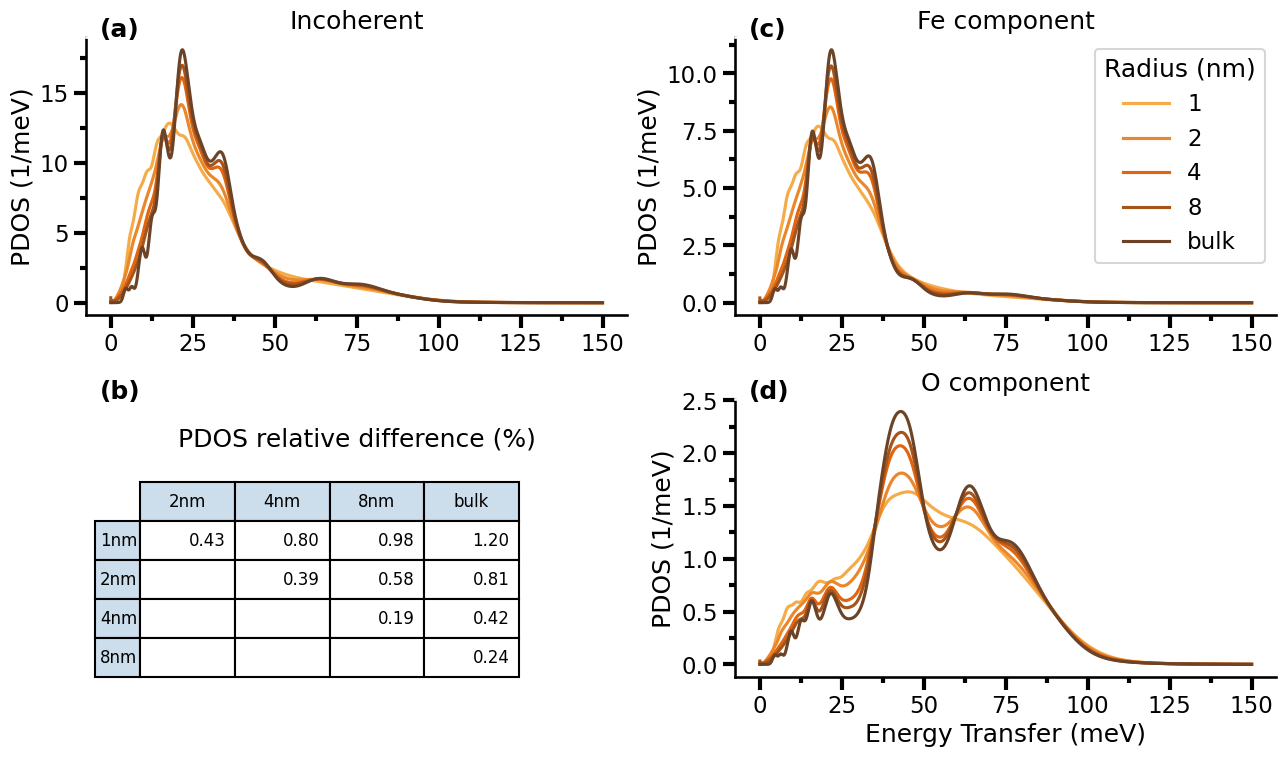

In [4]:
emin,emax=0,150
weight="Incoherent"
df_tmp=df_dos_gromacs.query(" %f < `Energy Transfer (meV)` and `Energy Transfer (meV)` < %f and Weight== '%s' and `Temperature (K)` == 300 "%(emin,emax,weight))

df_diff_list=list()
radius_list=df_tmp["Radius (nm)"].unique()
for r1,r2 in zip(radius_list[:-1],radius_list[1:]):
        df1=df_tmp.query('`Radius (nm)` == "%s"'%r1)
        df2=df_tmp.query('`Radius (nm)` == "%s"'%r2)
        Energy=df1['Energy Transfer (meV)'].values
        cs=CubicSpline(df2['Energy Transfer (meV)'],df2['Normalized Count'])
        df_tmp2=pd.DataFrame({"Energy Transfer (meV)":Energy,"Difference (%)":(df1['Normalized Count']-cs(Energy))*100,"Comparison":"%s-%s"%(r1,r2)})
        df_diff_list.append(df_tmp2)
df_gmx_diff=pd.concat(df_diff_list,ignore_index=True)


data_list=list()
radius_list=df_tmp["Radius (nm)"].unique()
for r1 in radius_list:
    for r2 in radius_list:
        df1=df_tmp.query('`Radius (nm)` == "%s"'%r1)
        df2=df_tmp.query('`Radius (nm)` == "%s"'%r2)
        Energy=df1['Energy Transfer (meV)'].values
        cs=CubicSpline(df2['Energy Transfer (meV)'],df2['Normalized Count'])
        diff=np.abs(cs(Energy)-df1['Normalized Count'])
        mid=0.5*np.abs(cs(Energy)+df1['Normalized Count'])
        data_list.append({"R1":r1,"R2":r2,"Norm":100*simps(diff,Energy)/simps(mid)})
df_comparison=pd.DataFrame(data_list).query("R1<R2").pivot_table(values='Norm', index="R1",columns=['R2'], aggfunc="sum")



fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(7*2,4*2)
                       )
sns.set_context("talk")



labx=0.025
laby=1

ax=axs[0,0]
ax.text(labx, laby, '(a)',weight='bold' ,transform=ax.transAxes)
ax.set_title(weight)

sns.lineplot(data=df_tmp
                    ,y="Normalized Count"
                    ,x='Energy Transfer (meV)'
                    ,hue="Radius (nm)"
                     ,ax=ax
                     ,palette="YlOrBr_d"
                     ,legend=False
               )



ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('1')
ax.spines['right'].set_color('1')
ax.spines['left'].set_color('0')
ax.tick_params(direction='out', width=3, bottom=True, left=True)
ax.grid(False)
ax.set_xlabel("")
ax.set_ylabel("PDOS (1/meV)")

ax.xaxis.set_minor_locator(MultipleLocator(25/2))
ax.yaxis.set_minor_locator(MultipleLocator(5/2))
ax.tick_params(which='minor', length=4, width=3)

ax=axs[1,0]
ax.text(labx, laby, '(b)',weight='bold' ,transform=ax.transAxes)

# hide axes
ax.axis('off')
ax.axis('tight')

row_headers=["%snm"%x if len(x)==1 else x for x in df_comparison.index]
column_headers=["%snm"%x if len(x)==1 else x for x in df_comparison.columns]
rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.2))
ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.2))

table_len=df_comparison.shape[1]

table = ax.table(cellText=df_comparison.applymap(lambda x : "%.2f"%x if not np.isnan(x) else "").values
                 , colLabels=column_headers
                 ,colColours=ccolors
                 , bbox=[0.1,0,0.7,0.7]
                 ,rowColours=rcolors
                 , rowLabels=row_headers
                 )
table.auto_set_font_size(False)
table.set_fontsize(12)
ax.set_title("PDOS relative difference (%)",y=0.8)


ax=axs[0,1]
ax.text(labx, laby, '(c)',weight='bold' ,transform=ax.transAxes)
ax.set_title("Fe component")

sns.lineplot(data=df_tmp
                    ,y="Fe"
                    ,x='Energy Transfer (meV)'
                    ,hue="Radius (nm)"
                     ,ax=ax
                     ,palette="YlOrBr_d"
                     ,legend=True
               )

ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('1')
ax.spines['right'].set_color('1')
ax.spines['left'].set_color('0')
ax.tick_params(direction='out', width=3, bottom=True, left=True)
ax.grid(False)
ax.set_xlabel("")
ax.set_ylabel("PDOS (1/meV)")

ax.xaxis.set_minor_locator(MultipleLocator(25/2))
ax.yaxis.set_minor_locator(MultipleLocator(2.5/2))
ax.tick_params(which='minor', length=4, width=3)

ax=axs[1,1]
ax.text(labx, laby, '(d)',weight='bold' ,transform=ax.transAxes)
ax.set_title("O component")

sns.lineplot(data=df_tmp
                    ,y="O"
                    ,x='Energy Transfer (meV)'
                    ,hue="Radius (nm)"
                     ,ax=ax
                     ,palette="YlOrBr_d"
                     ,legend=False
               )

ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('1')
ax.spines['right'].set_color('1')
ax.spines['left'].set_color('0')
ax.tick_params(direction='out', width=3, bottom=True, left=True)
ax.grid(False)
ax.set_ylabel("PDOS (1/meV)")

ax.xaxis.set_minor_locator(MultipleLocator(25/2))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(which='minor', length=4, width=3)


# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.95, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3
                   )

plt.savefig("../figures/fig5.pdf", pad_inches=0.2,bbox_inches="tight")